In [2]:
import numpy as np

import scipy.stats as st
import matplotlib as mpl
import matplotlib.pyplot as plt
import plotting as pt

In [109]:
def simulate_bites(y,eir):
    '''
    Produces a vector with bite times up until year, y, is reached.

    Time between bites pulled from exponential distribution wih mean rate of k = eir/365.
    '''
    k = eir/365
    n = round(y*eir*2)
    spaces = st.expon.rvs(scale=(1/k), loc=0, size=n)
    times = np.cumsum(spaces)
    trimmed = times[times <= y*365]
    bites = np.ceil(trimmed).astype(int)
    return bites

def simulate_genotypes(n,a,power=1):
    '''
    n = number of strains to simulate
    a = vector whose length corresponds to number of loci.
    Each entry corresponds to the number of alleles at that loci.
    so a = [3,4,6] will simulate a strain with 3 loci. The first
    loci has 3 alleles; the second loci has 4 alleles, and the third
    loci has 6 alleles.

    Returns genotype as a L x n matrix, where L = the number of loci.
    '''
    length = len(a)
    M = np.empty((length,n),dtype=int)
    floats = np.random.power(power,(length,n))
    genotype = np.ceil(floats*np.repeat(a,n).reshape(length,n))-1
    M[:] = genotype
    return M

def get_mz(size,meroz=0.8,mshape=1):
    '''
    Generates starting number of merozoites from a lognormal distribution.
    Values from here: https://www.science.org/doi/10.1126/scitranslmed.aag2490
    '''
    mz = st.lognorm.rvs(s=mshape,scale=meroz,size=size)
    return mz

def get_r(size,growthrate=0.8,rscale=0.1):
    '''
    Generates r from normal distribution.
    Values from here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7198127/
    '''
    r = st.norm.rvs(loc = growthrate, scale=rscale,size=size)
    return r

def simulate_params(n,meroz,growthrate,mshape,rscale):
    '''
    Simulates mz and growth rate for strains.
    Returns 2 x n matrix.

    Inputs:
        n = number of strains
        meroz = average starting number of merozites
        growthrate = average starting growthrate
    '''
    M = np.zeros((2,n))
    M[0,:] = get_mz(n,meroz,mshape)
    M[1,:] = get_r(n,growthrate,rscale)
    return M

def create_allele_matrix(a,y):
    '''
    Creates matrix to track parasitemia.
    '''
    length = len(a)
    width = max(a)
    days = 365*y
    M = np.zeros((length,width,days))
    return M

def create_strain_matrix(n,y):
    '''
    Creates n x y*365 matrix to track strains presence per day.
    '''
    M = np.zeros((n,y*365))
    return M

def add_infection(t,j,mz,gtype,sM,pM):
    '''
    Adds infection to strain & parasite matrices.

    Inputs:
        t = time in days
        j = bite number
        mz = start of merozites
        gtype = genotype of infection
        sM = matrix tracking parasitemia by strain
        pM = matrix tracking parasitemia by allele
    '''
    sM[j,t] = mz
    n_loci = len(gtype)
    pM[np.arange(n_loci),(gtype),t] += mz

def update_immunity(t,pM,iM,gamma): # Use with np.vectorize()
    '''
    Immunity exponentially decays if parasite not present.

    Inputs:
        t = time in days
        locus = locus number
        allele = allele number
        pM = matrix tracking parasitemia by allele
        iM = matarix tracking immunity by allele
        tHalf = half-life of immunity
    '''
    if t >= 14:
        iM[:,:,t] = iM[:,:,t-1]*np.exp(-gamma)
        iM[:,:,t][pM[:,:,t-14]>0] = 1

def get_strain_immunity(gtype,i2,w,rows):
    '''
    Returns immunity to strain.
    gtype = genotype of strain
    i2 = immune matrix at t of interest.
    w = vector weighting immunity by allele
    '''
    crossed = i2[rows,gtype]
    imm = (crossed*np.asarray(w)).sum(axis=1)
    return imm

def modulate_growth_rate(imm,r0,rend=-0.05,xh=0.3, b=-2):
    '''
    Modulates growth rate based on immunity.
    rend = final growth rate at full immunity
    xh = inflection point for % immunity change
    b = intensity of immune effect
    '''
    c = np.tan(np.pi/2*xh)**b
    r = ((r0-rend)/(c/np.tan(np.pi/2*imm)**b+1)) + rend
    return r

def get_parasitemia(p0,r,k = 5*10**5,pgone=0.001):
    '''
    Returns parasitemia given growth rate & carrying capacity.
    '''
    rpos = k/(1+((k-p0)/p0)*np.exp(-r))
    rneg = p0*np.exp(r)
    p = rneg
    p[r>0] = rpos[r>0]
    p[p<pgone]= 0
    return p

def update_parasitemia(t,active,w,gM,iM,rV,sM,pM,k = 5*10**5,rend=-0.05,xh=0.3,b=-2,pgone=0.001): 
    '''
    Updates parasitemia for each strain and allele by bite number.

    Inputs:
        t = time in days
        j = bite number
        w = vector weighting immunity by allele
        gM = genotype matrix
        iM = immune matrix
        rV = vector tracking initial growth rate by bite number.
        sM = matrix tracking parasitemia by strain
        pM = matrix tracking parasitemia by allele
        k = carrying capacity
        rend = growth rate with 100% immunity
        xh = param scaling immunity's impact on growth rate
        b = param scaling immunity's impact on growth rate
        pgone = threshold below which infection goes to zero
    '''
    active = np.asarray(list(active),dtype=int)
    gtype = gM[:,active].T
    n_strains,n_loci = gtype.shape
    rows = np.broadcast_to(np.arange(n_loci),(n_strains,n_loci))
    imm = get_strain_immunity(gtype,iM[:,:,t-1],w,rows)
    r = modulate_growth_rate(imm,rV[active],rend,xh,b)
    
    p0 = sM[active,t-1]
    p = get_parasitemia(p0,r,k=k,pgone=pgone)
    sM[active,t] = p
    loci,alleles = iM[:,:,t].shape
    zeroth = np.zeros((n_loci,alleles,n_strains))

    strained = np.broadcast_to(np.arange(n_strains),(n_loci,n_strains)).T
    zeroth[rows,gtype,strained] = np.broadcast_to(p,(n_loci,n_strains)).T
    psum = np.sum(zeroth,axis=2)
    pM[:,:,t] = psum
    done = set(active[p==0])
    return done

def get_fever_threshold(arr,t):
    '''
    Returns fever threshold at t
    '''
    thresh = arr[arr[:,0]>=(t/365),1][0]
    return thresh

def treat_malaria(t, threshhold, pM, sM, m,a):
    '''
    Treat if parasitemia goes above certain threshold. Modifies parasite density
    matrix & strain matrix. Returns updated list with days malaria has occured.
        threshold = threshold for treatment
        pM = matrix tracking parasite density by allele across time.
        sM = matrix tracking parasitemia by strain across time.
        m = list with days malaria has occured
    '''
    if pM[0,:,t-1].sum(axis=0) > threshhold:
        pM[:,:,t] = 0
        sM[:,t] = 0
        m.append(t-1)
        a = set()
    return m,a

def load_data():
    '''
    Loads data used in the model
    '''
    fever = np.load("../data/fever.npy")
    breaks = np.load("../data/breaks.npy")
    return fever, breaks

def get_fever_arr(eir,fever,breaks):
    '''
    Returns 40 x 2 array, where column 0 is age cutoffs, and column 1 is parasite density
    for fever threshold at that age.
    '''
    eir_loc = (breaks[:,2]>=eir).nonzero()[0][0]
    age_index,pardens_index = (fever[:,:,eir_loc]).nonzero()
    age_breaks, age_loc = np.unique(age_index,return_index=True)
    pdens = breaks[pardens_index[age_loc],1]
    age = breaks[age_breaks,0]
    arr = np.stack((age,10**pdens),axis=1)
    return arr

def simulate_person(y,eir,a,w,meroz=0.8,growthrate=1.2,mshape=1,rscale=0.1,tHalf=100,rend=-0.05,xh=0.3,b=-2,k=5*10**5,pgone=0.001,power=1):
    '''
    Runs simulation for one person. Returns matrix tracking parasitemia by allele,
    matrix tracking immunity by allele, matrix tracking parasitemia by strain, and
    a list containing the days of every malaria episode someone had.

    Inputs:
        y = years to simulate
        eir = entomological inoculation rate
        a = vector with number of allels per loci
        meroz = average starting number of merozites
        growthrate = average starting growthrate
        w = vector weighting immunity by allele
        k = carrying capacity
        rend = growth rate at 100% immmunity
        xh = param scaling immunity's impact on growth rate
        b = param scaling immunity's impact on growth rate
        pgone = threshold below which infection goes to zero
    '''
    # Simulates bites & strain characteristics
    bites = simulate_bites(y,eir)
    n = len(bites)
    gtypes = simulate_genotypes(n,a)
    params = simulate_params(n,meroz,growthrate,mshape=mshape,rscale=rscale)
    gamma = 0.693/tHalf

    # Creates objects to record
    pM = create_allele_matrix(a,y)
    iM = create_allele_matrix(a,y)
    sM = create_strain_matrix(n,y)
    malaria = []
    active = set()

    # Runs forward time simulation
    ## Day 0:
    t = 0
    if t in bites: # Case where first bite is on day zero.
        locs = np.where(bites == t)
        for j in locs[0]:
            add_infection(t,j,params[0,j],gtypes[:,j],sM,pM)
            active.add(j)

    ## Day 1+
    for t in np.arange(1,y*365):
        if active:
            drop = update_parasitemia(t=t,active=active,w=w,gM=gtypes,iM=iM,rV=params[1,:],sM=sM,pM=pM,k=k,rend=rend,xh=xh,b=b,pgone=pgone)
            if drop:
                active = active.difference(drop)
        if t in bites:
            if not len(malaria) > 0 or t - malaria[-1] > 14:
                locs = np.where(bites == t)
                for j in locs[0]:
                    add_infection(t,j,params[0,j],gtypes[:,j],sM,pM)
                    active.add(j)
        thresh = get_fever_threshold(fever_arr, t)
        malaria,active = treat_malaria(t,thresh,pM,sM,malaria,active)
        update_immunity(t=t,pM=pM,iM=iM,gamma=gamma)
    return pM, iM, sM, malaria

def simulate_cohort(n_people,y,eir,a,w,meroz=0.8,growthrate=1.2,mshape=1,rscale=0.1,tHalf=100,rend=-0.05,xh=0.3,b=-2,k=5*10**5,pgone=0.001):
    '''
    Simulates an entire cohort of individuals.

    Returns n_people x loci x alleles x t matrices tracking parasite density & immunity at each allele.
    Returns dictionary containing strain matrices for each person.
    Returns dictionary containing lists of malaria episodes for each person.
    Returns dictionary containing infection matrices for each person.

    Input:
        y = years to simulate
        a = vector of len(loci) specifying number of alleles at each locus
        w = immune weighting for each locus
        delta = immunity waning rate
    '''
    # Create objects to record
    all_parasites = np.zeros((n_people, len(a), max(a), y*365))
    all_immunity = np.zeros((n_people, len(a), max(a), y*365))
    all_strains = {}
    all_malaria = {}

    # Load dataset for fever threshhold
    fever, breaks = load_data()
    fever_arr = get_fever_arr(eir,fever,breaks)

    # Simulate people
    for person in range(n_people):
        pmatrix, imatrix, smatrix, malaria = simulate_person(y,eir,a,w,meroz=meroz,growthrate=growthrate,mshape=mshape,rscale=rscale,tHalf=tHalf,rend=rend,xh=xh,b=b,k=k,pgone=pgone)
        all_parasites[person,:,:,:] = pmatrix
        all_immunity[person,:,:,:] = imatrix
        all_strains[person] = smatrix
        all_malaria[person] = malaria

    return all_parasites, all_immunity, all_strains, all_malaria

In [110]:
y = 5
eir = 40
a = np.repeat(10,5)
w = np.repeat(1/5, 5)
fever,breaks = load_data()
fever_arr = get_fever_arr(eir,fever,breaks)
n_people=100

In [111]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [112]:
%lprun -f update_parasitemia simulate_person(y,eir,a,w)

/var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_76860/1596461574.py:132: RuntimeWarning: divide by zero encountered in power
  r = ((r0-rend)/(c/np.tan(np.pi/2*imm)**b+1)) + rend


Timer unit: 1e-09 s

Total time: 0.109429 s
File: /var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_76860/1596461574.py
Function: update_parasitemia at line 146

Line #      Hits         Time  Per Hit   % Time  Line Contents
   146                                           def update_parasitemia(t,active,w,gM,iM,rV,sM,pM,k = 5*10**5,rend=-0.05,xh=0.3,b=-2,pgone=0.001): 
   147                                               '''
   148                                               Updates parasitemia for each strain and allele by bite number.
   149                                           
   150                                               Inputs:
   151                                                   t = time in days
   152                                                   j = bite number
   153                                                   w = vector weighting immunity by allele
   154                                                   gM = genotype matrix
   155      

In [151]:
pmatrix,imatrix,smatrix,malaria= simulate_person(y,eir,a,w)

/var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_76860/1596461574.py:132: RuntimeWarning: divide by zero encountered in power
  r = ((r0-rend)/(c/np.tan(np.pi/2*imm)**b+1)) + rend


In [168]:
def get_visits(malaria,period,y):
    '''
    Returns passive & active visit dates in a list.
    '''
    start = np.random.randint(1,period)
    if start > malaria[0]:
        start = malaria[0]
    active = np.arange(start,y*365,period)
    visits = np.union1d(active,malaria)
    return visits

def get_Parasitemia(pmatrix,visits):
    '''
    Returns prevalence & parasite density (if parasites) for every visit. 
    Parasite density does not include Zeros.
    '''
    results = pmatrix[0,:,visits].sum(axis=1)
    pdens = results[results != 0]
    prev = np.count_nonzero(results)/len(results)
    return pdens, prev

def get_asymps(pmatrix,visits,malaria):
    '''
    Returns day of first asymptomatic parasitemia
    '''
    pdens = pmatrix[0,:,visits].sum(axis=1)
    locs = np.flatnonzero(pdens)
    pos = visits[locs]
    asymps = np.setdiff1d(pos, malaria)
    return asymps

def get_spacing(asymps, malaria):
    '''
    Returns time window between first asymptomatic case & last symptomatic case
    '''
    diff = malaria[-1] - asymps[0]
    return diff

def get_intermediate_density(visits,asymps, malaria, pmatrix):
    '''
    Returns mean measured parasite density during inbetween period. This mean does include zero values.
    Also returns % lamp only & % microscopy only. Sets microscopy cutoff at 90.
    '''
    between = visits[(visits >= asymps[0]) & (visits <= malaria[-1])]
    pdens = pmatrix[0,:,between].sum(axis=1)
    lamp = len(pdens[pdens>1])/len(pdens)
    micro = len(pdens[pdens>90])/len(pdens)
    mean = np.mean(pdens)
    return mean,lamp,micro

def get_yearly_cases(malaria,y):
    '''
    Returns number of cases for each year.
    '''
    starts = 365*np.arange(y)
    ends = 365*np.arange(1,y+1)
    malaria = np.asarray(malaria)
    cases = [len(malaria[(malaria < end) & (malaria>=start)]) for start,end in zip(starts,ends)]
    return cases

def get_yearly_prevs(pmatrix,visits,y):
    '''
    Returns number of cases for each year.
    '''
    starts = 365*np.arange(y)
    ends = 365*np.arange(1,y+1)
    times = [visits[(visits < end) & (visits>=start)] for start,end in zip(starts,ends)]
    n_visits = np.asarray([len(time) for time in times])
    pdens = [pmatrix[0,:,check].sum(axis=1) for check in times]
    micros = [len(pden[pden>90]) for pden in pdens]
    lamps = [len(pden[pden>1]) for pden in pdens]
    micro = np.asarray(micros)/n_visits
    lamp = np.asarray(lamps)/n_visits
    return micro,lamp

In [161]:
visits = get_visits(malaria,30,y)
asymps = get_asymps(pmatrix,visits,malaria)
between = get_spacing(asymps,malaria)
interm,lamp,micro = get_intermediate_density(visits,asymps,malaria,pmatrix)

In [162]:
malaria

[14, 42, 76, 138, 181, 279]

In [169]:
get_yearly_prevs(pmatrix,visits,y)

(array([0.5, 0. , 0. , 0. , 0. ]),
 array([0.83333333, 1.        , 1.        , 0.91666667, 1.        ]))

In [126]:
between

48

In [127]:
interm

6470.755971171125

In [128]:
lamp

0.75

In [129]:
micro

0.5

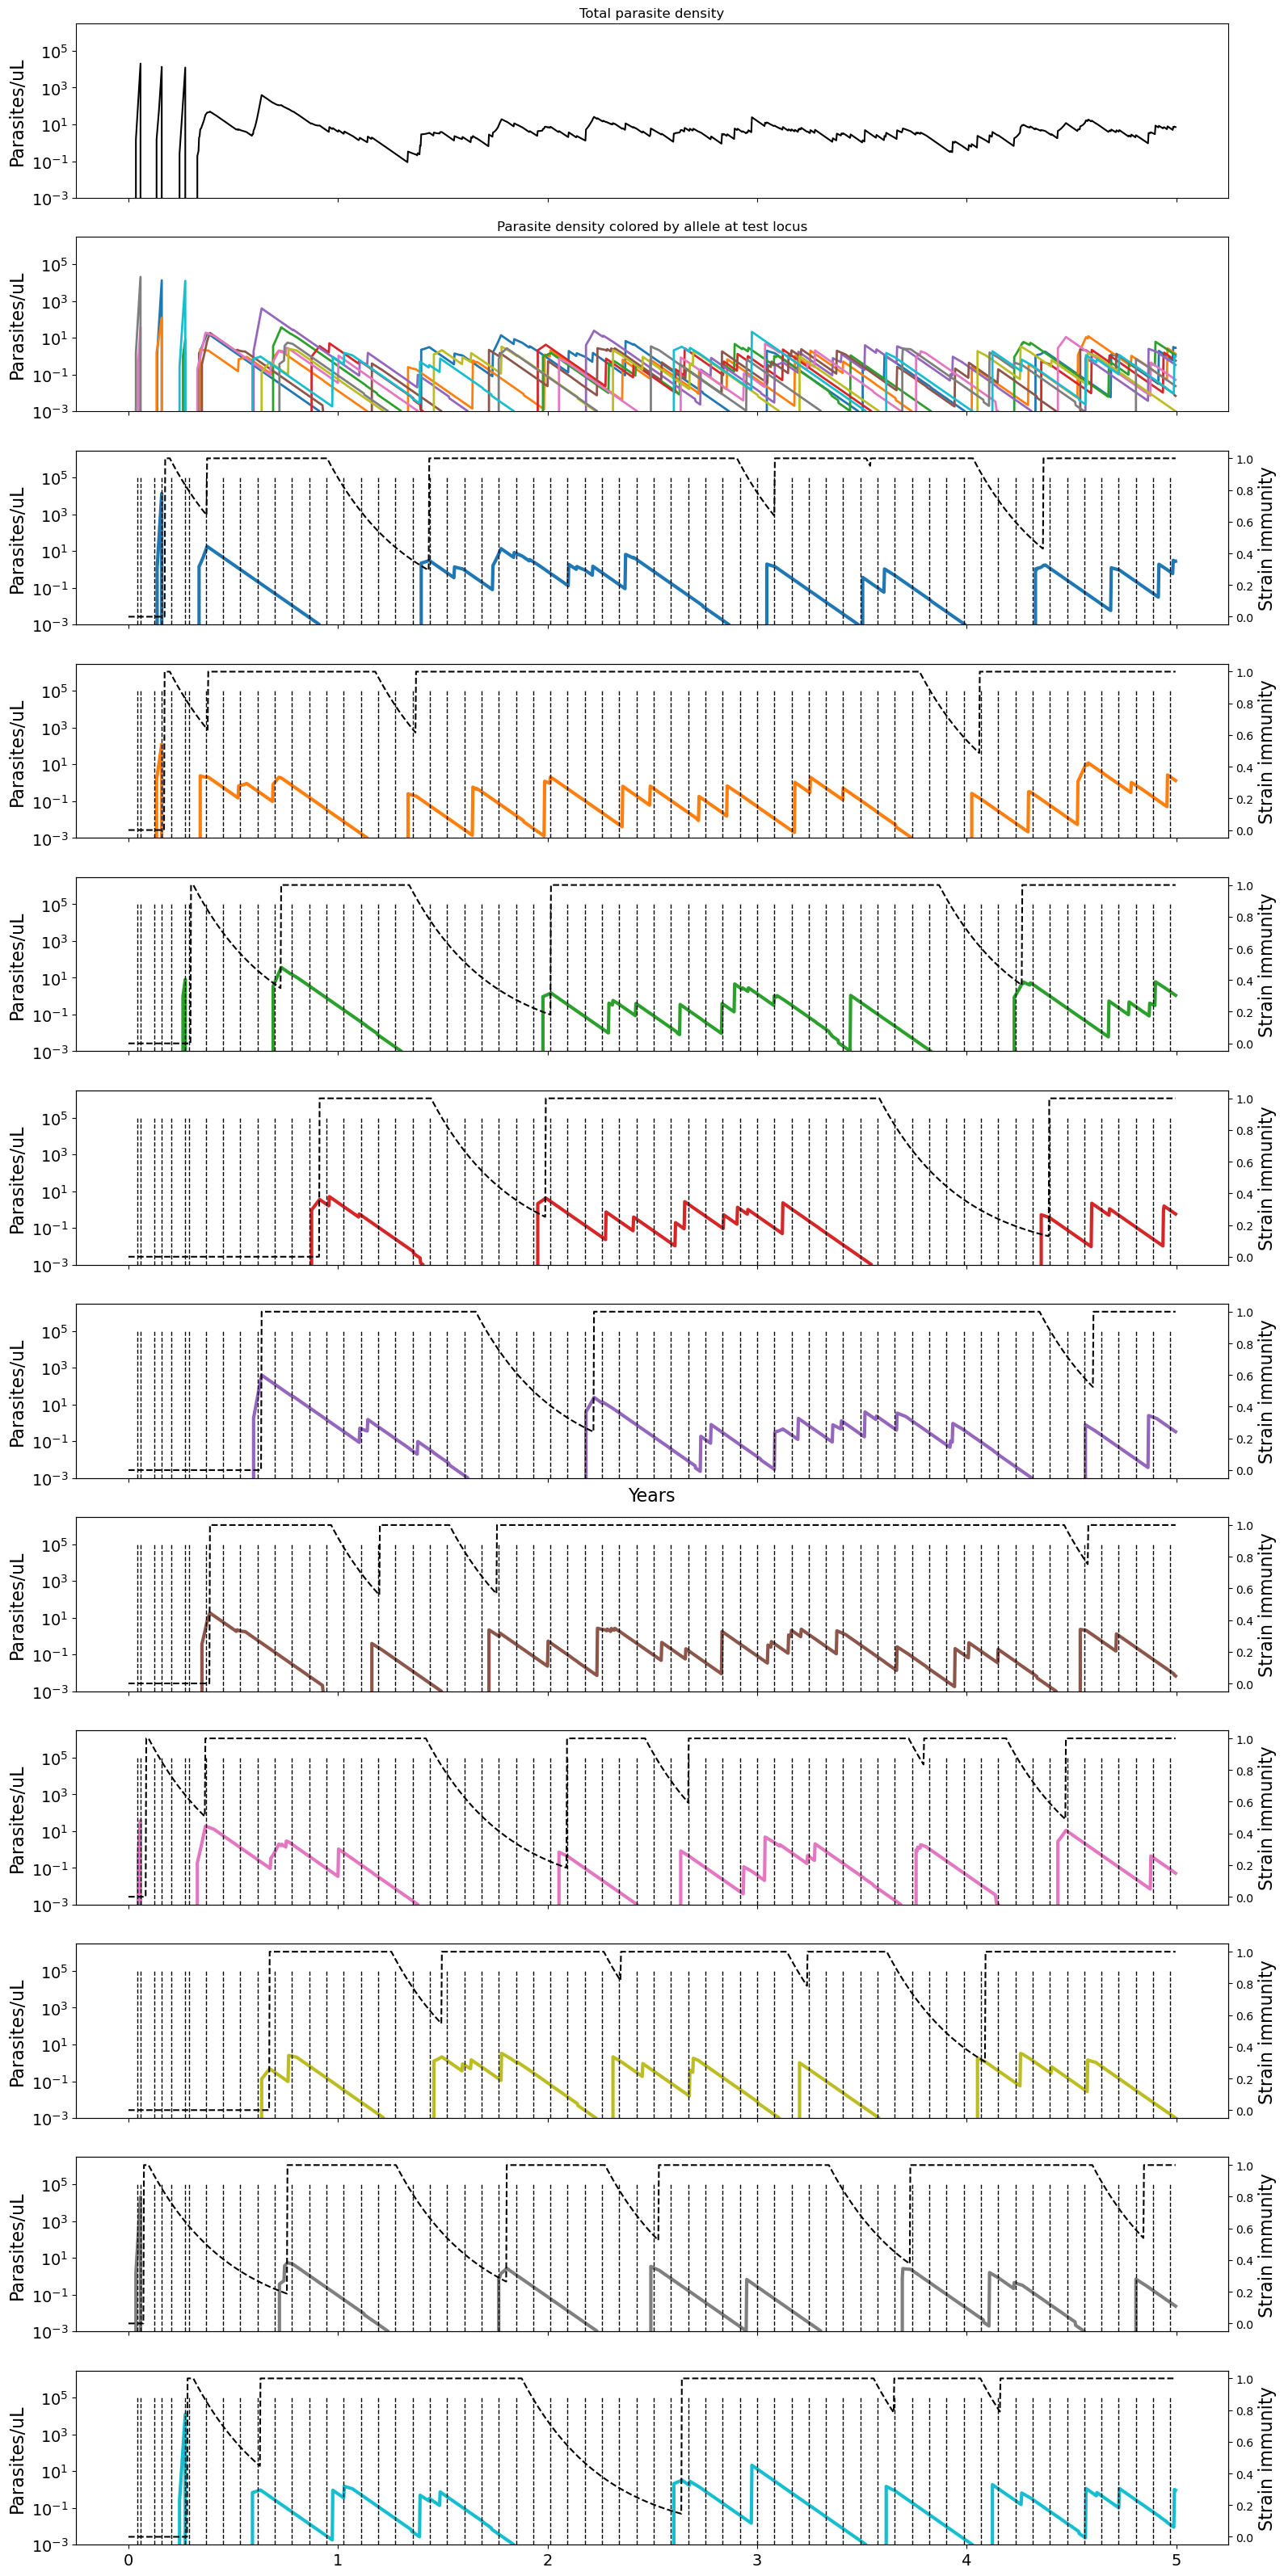

In [119]:
colors = {0:"tab:blue", 1:"tab:orange", 2:"tab:green", 3:"tab:red", 4:"tab:purple", 5:"tab:brown", 6:"tab:pink",7:"tab:olive",8:"tab:grey",9:"tab:cyan"}

fig, ax = plt.subplots(nrows=12, sharey=True, sharex=True, tight_layout=True, figsize=(16,32))
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_yscale('log')
ax[0].plot(np.arange(y*365)/365, pmatrix[-1,:,:].sum(axis=0),color="black")
for strain in np.arange(a[-1]):
    iStrain = pmatrix[-1,strain,:]
    if np.sum(iStrain) > 1:
        ax[1].plot(np.arange(y*365)/365, iStrain, linewidth=2,color=colors[strain])
ax[0].set_ylim(0.001,3000000)
ax[6].set_xlabel('Years',fontsize=16)
ax[0].set_ylabel('Parasites/uL',fontsize=16)
ax[0].set_title('Total parasite density')
ax[1].set_title('Parasite density colored by allele at test locus')
ax[1].set_ylabel('Parasites/uL',fontsize=16)
for row in range(2,12):
    ax[row].tick_params(axis='both', which='major', labelsize=14)
    ax[row].set_ylabel('Parasites/uL',fontsize=16)
    other = [strain for strain in range(0,5) if strain != row-2]
    ax[row].plot(np.arange(y*365)/365, pmatrix[-1,row-2,:],linewidth=3,color=colors[row-2])
    ax[row].vlines(x=np.asarray(visits)/365,ymin=0.001,ymax=100000,color="black",linestyle="dashed",linewidth=1)

    #for strain in other:
     #   ax[row].plot(np.arange(y*365)/365, all_parasites[i,-1,strain,:],linewidth=2,alpha=0.2,color=colors[strain])

    ax2 = ax[row].twinx()
    ax2.set_ylabel('Strain immunity',fontsize=16)
    ax2.plot(np.arange(y*365)/365, imatrix[-1,row-2,:],linewidth=1.5,color='black',linestyle='dashed')

In [40]:
%lprun -f simulate_person simulate_cohort(n_people,y,eir,a,w)

/var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_76860/2633407161.py:132: RuntimeWarning: divide by zero encountered in power
  r = ((r0-rend)/(c/np.tan(np.pi/2*imm)**b+1)) + rend


Timer unit: 1e-09 s

Total time: 10.1799 s
File: /var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_76860/2633407161.py
Function: simulate_person at line 229

Line #      Hits         Time  Per Hit   % Time  Line Contents
   229                                           def simulate_person(y,eir,a,w,meroz=0.8,growthrate=1.2,mshape=1,rscale=0.1,tHalf=100,rend=-0.05,xh=0.3,b=-2,k=5*10**5,pgone=0.001,power=1):
   230                                               '''
   231                                               Runs simulation for one person. Returns matrix tracking parasitemia by allele,
   232                                               matrix tracking immunity by allele, matrix tracking parasitemia by strain, and
   233                                               a list containing the days of every malaria episode someone had.
   234                                           
   235                                               Inputs:
   236                         

In [12]:
all_parasites, all_immunity, all_strains, all_malaria = simulate_cohort(n_people,y,eir,a,w)

/var/folders/b5/2grxct1x69395r8j6vkk07bc0000gp/T/ipykernel_38737/2633407161.py:132: RuntimeWarning: divide by zero encountered in power
  r = ((r0-rend)/(c/np.tan(np.pi/2*imm)**b+1)) + rend


In [13]:
pt.check_outcomes(a,5,all_parasites,all_immunity,all_strains,all_malaria)

TypeError: check_infection_length() takes 1 positional argument but 3 were given

In [ ]:
def get_peaks(pdensity):
    '''
    Finds the time of all parasite density peaks
    '''
    lag = np.pad(pdensity,1,mode='constant')[:-2]
    sign = np.sign(pdensity-lag).astype(int)
    lead = np.pad(sign,(0,1), mode='constant')[1:]
    peak = np.where(sign > lead)[0]
    return peak

In [ ]:
pdensity = pmatrix[0,:,:].sum(axis=0)

get_peaks(pdensity)


In [536]:
np.where(smatrix>0)[1]

array([   4,    5,    6, ..., 2917, 2918, 2919])

1.0328715279677227


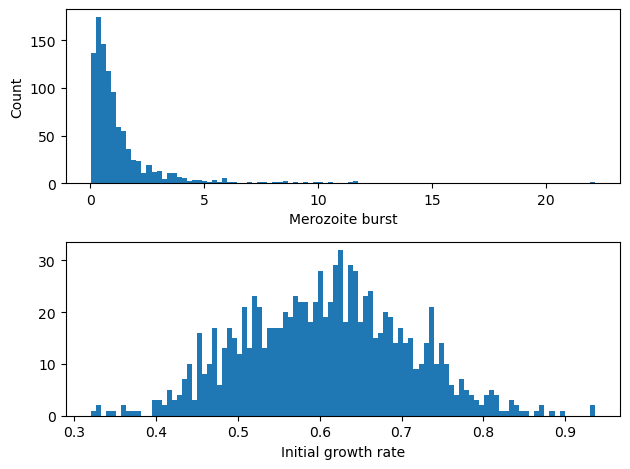

In [562]:
params = np.zeros((2,1000))

size=1000
params[0,:] = get_mz(size,0.8,1)
params[1,:] = get_r(size,0.6,0.1)
    
fig,ax = plt.subplots(nrows=2, tight_layout = True)
ax[0].hist(params[0,:],bins=100)
#ax[1].hist(np.exp(params[1,:]*2),bins=100)
ax[1].hist(params[1,:],bins=100)
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Count")
ax[0].set_xlabel("Merozoite burst")
ax[1].set_xlabel("Initial growth rate")
#fig.savefig("../figs/starting_params.pdf")
print(np.median(params[0,i]))

In [553]:
params[0,:].min()

1.6619747662529556

In [ ]:
def modulate_growth_rate(imm,r0,rend=-0.05,xh=0.2, b=-2):
    '''
    Modulates growth rate based on immunity.
    '''
    if imm == 0:
        return r0
    else:
        c = np.tan(np.pi/2*xh)**b
        r = ((r0-rend)/(c/np.tan(np.pi/2*imm)**b+1)) + rend
    return r

In [ ]:
imms = np.arange(0,1,0.01)
rates = np.arange(0.3,0.9,0.1)

ends = np.zeros((len(rates),len(imms)))

for i,rate in enumerate(rates):
    for j,imm in enumerate(imms):
        ends[i,j] = modulate_growth_rate(imm,rate)

fig, ax = plt.subplots()

for i,rate in enumerate(rates):
    ax.plot(imms, ends[i,:], linewidth=2, label = rate)
ax.set_xlabel("Immunity", fontsize=16)
ax.set_ylabel("Growth rate",fontsize=16)
ax.hlines(y=0, xmin = 0, xmax=1,color='k',linestyle='--')
ax.legend()
#fig.savefig("figs/r_immunity.pdf")

In [ ]:
growth_rate(0.5,1.4)

In [ ]:
growth_rate(0.95,1.3)

In [ ]:
a = 1 # shape
samples = 1000
s = np.random.power(a, samples)

import matplotlib.pyplot as plt
count, bins, ignored = plt.hist(s, bins=30)
x = np.linspace(0, 1, 100)
y = a*x**(a-1.)
normed_y = samples*np.diff(bins)[0]*y
plt.plot(x, normed_y)
plt.show()

In [4]:
def check_infection_length(sM,y, malaria):
    lengths = []
    infections = len(sM)
    for i in range(infections):
        counter = 0
        for j in range(y*365):
            if sM[i,j] > 0:
                counter += 1
                if j in malaria:
                    counter = 0
        if counter > 0:
            lengths.append(counter)
    return lengths

array([1., 1., 0., 1.])

In [109]:
np.sum(np.sign(smatrix),axis=1)

array([10.,  3.,  2., ...,  5.,  2.,  0.])

0